#Building 3 layer Neural Network using Numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

#Generating sample data for 3d input and 2d output


In [2]:
def get_true_labels(X, weights_true, bias_true):
  return (X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [3]:
n_samples = 150
input_dim = 3
output_dim = 2

np.random.seed(123)
X = np.random.uniform(-1, 1, (n_samples, input_dim))
print('Sample X: ' + str(X[:3]))

weights_true = np.array([[5, 1, 3], [2, 1, 1]])
bias_true = np.array([[1], [1]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:3]))

Sample X: [[ 0.39293837 -0.42772133 -0.54629709]
 [ 0.10262954  0.43893794 -0.15378708]
 [ 0.9615284   0.36965948 -0.0381362 ]]
Sample y: [[ 2.74834914  1.6020455 ]
 [ 1.80700641  1.72779256]
 [10.8265884   5.24175629]]


# Drawing the 3 Dimensional data plot

In [4]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

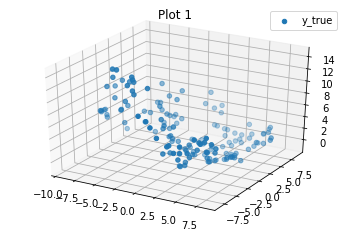

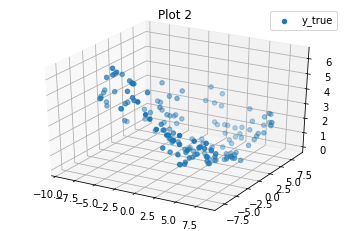

In [5]:
plot_3d('Plot 1', X, y_true[:,0])
plot_3d('Plot 2', X, y_true[:,1])

#Building Nueral Network

##Loss Function - MSE

In [6]:
# Mean Squared Error
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient


##Linear Layer

In [7]:
class Layer:

  #Randomly initialize the weight and bias
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    self.weights = np.random.rand(num_input_nodes, num_output_nodes)
    self.bias = np.random.rand((1))
    self.X = np.zeros([num_input_nodes])
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  #Compute forward pass
  def forward(self, X):
    self.X = X.copy()
    self.Z = X @ self.weights + self.bias
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  #Perform gradient descent
  def backward(self, upstream_gradient):
    curr_upstream_gradient = upstream_gradient.copy()
    if self.activation != None:
      curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)
    
    # Compute gradient by taking dot product local gradient with upstream gradient
    self.dJdW = self.X.T @ curr_upstream_gradient
    # Upstream gradient is the sum of the gradient
    self.dJdb = curr_upstream_gradient.sum()
    # Compute the gradient of input X wrt to loss
    self.dJdX = curr_upstream_gradient @ self.weights.T
    return self.dJdX

  # Update weight and bias params with learning rate
  def update(self, learning_rate):
    self.weights = self.weights - learning_rate * self.dJdW
    self.bias = self.bias - learning_rate * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)


##ReLU Activation function

In [8]:
class Relu:
  def __init__(self):
    self.input = np.array([])

  #Fowrard pass
  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  #Backpropogation
  def backward(self, upstream_gradient):
    return (self.input > 0) * upstream_gradient
  
  # No update needed to ReLU members
  def update(self, learning_rate):
    return

  def __str__(self):
    return 'ReLu'

##Neural Net Architecture

In [9]:
class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    curr_out = inputs.copy()
    for l in self.layers:
      curr_out = l.forward(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('Error: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()

    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, learning_rate):
    for layer in self.layers:
      layer.update(learning_rate)
  
  # Training loop over number of epochs
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(learning_rate)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

#HyperParameters

In [10]:
epochs = 150
learning_rate = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

#Training NN without any activation fucntion

In [11]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.09342707 0.83746611 0.41026572 0.66171654]
 [0.94320056 0.24513059 0.01315983 0.02414841]
 [0.70938569 0.92455188 0.46733027 0.37510915]]
Bias:[0.54286042]
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.85891684 0.65215387 0.2329799 ]
 [0.7745802  0.1346135  0.16555997]
 [0.61268228 0.23878341 0.70477855]
 [0.34951853 0.27742396 0.99891841]]
Bias:[0.04061612]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.64582252 0.03869959]
 [0.76021026 0.23008996]
 [0.08983187 0.64844971]]
Bias:[0.73260122]

Error:  5.472127050818176
Error:  3.8918330052595516
Error:  3.2337924387717596
Error:  2.957963470483134
Error:  2.7581403677685667
Error:  2.5876772781130866
Error:  2.442929151960004
Error:  2.3221770403483113
Error:  2.2232274522114746
Error:  2.1434144768298906
Error:  2.079828298113872
Error:  2.02957924033657

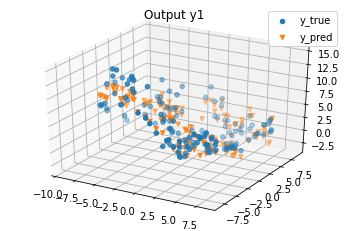

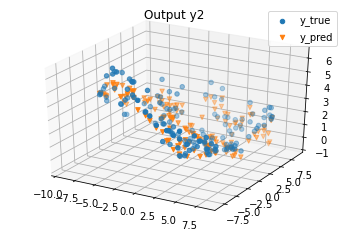

In [12]:
plot_3d('Output y1', X, y_true[:,0], y_pred[:,0])
plot_3d('Output y2', X, y_true[:,1], y_pred[:,1])

#Training NN with ReLU activation function

In [13]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[6.78095315e-01 5.19009471e-02 2.94306946e-01 4.51088346e-01]
 [2.87103290e-01 8.10513456e-01 1.31115105e-01 6.12179362e-01]
 [9.88214944e-01 9.02556539e-01 2.22157062e-01 8.18876137e-05]]
Bias:[0.98059734]
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[0.88271298 0.91947247 0.41550355]
 [0.74461546 0.2128315  0.39230407]
 [0.85154805 0.12761222 0.89386537]
 [0.49650797 0.42609566 0.30564639]]
Bias:[0.91684879]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.51762346 0.80402637]
 [0.85765179 0.92238235]
 [0.30338073 0.33981085]]
Bias:[0.59507388]

Error:  17.328624230857287
Error:  5.619343986270136
Error:  4.477036200309248
Error:  3.932932163618256
Error:  3.654942818550437
Error:  3.4539339791583243
Error:  3.2787620417325165
Error:  3.1181608308193165
Error:  2.9706421627992667
Error:  2.832699702615307
Erro

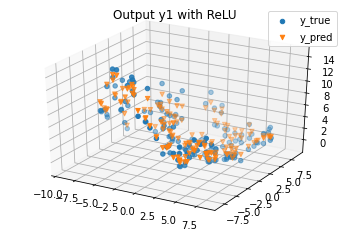

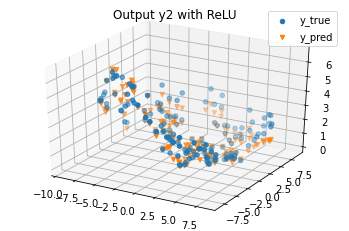

In [14]:
plot_3d('Output y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output y2 with ReLU', X, y_true[:,1], y_pred[:,1])